Open Play Shots - Expected Behind Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import open_shots_file_path
# from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
# from total_points_model.domain.contracts.mappings import Mappings
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 1
model_name = "expected_behind_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_BEHIND

Load Data

In [6]:
df_modelling = pd.read_csv(open_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
9211,211,kickIn,behind,1705.0,4,744,775.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,56.0,-36.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,1,0,1,108.0,33.0,75.0,Kick,Gather,Kick,Handball Received,56.0,48.0,7.0,4.0,-36.0,-44.0,-47.0,-37.0,775.0,771.0,769.0,766.0,31.0,4.0,11.313708,24.0,36.0,43.266615,0.982794,56.309932,0.082503,4.727050,0.258900,14.833859,576.0,3.178054,False,56,True
9212,212,kickIn,goal,1740.0,4,787,900.0,Geelong,Geelong,Brandan Parfitt,Brandan_Parfitt,Kick,75.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,109.0,34.0,75.0,Kick,Handball Received,Handball,Loose Ball Get,75.0,75.0,76.0,75.0,0.0,-1.0,-5.0,-6.0,900.0,899.0,898.0,897.0,113.0,1.0,1.000000,5.0,0.0,5.000000,0.000000,0.000000,2.168022,124.218492,-1.429422,-81.899864,25.0,1.609438,False,76,True
9213,218,possGain,goal,1837.0,4,1136,1198.0,Geelong,Geelong,Sam De Koning,Sam_De_Koning,Kick,78.0,1.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,115.0,40.0,75.0,Kick,Gather,Kick,Handball Received,78.0,78.0,65.0,64.0,1.0,1.0,-12.0,-9.0,1198.0,1193.0,1190.0,1188.0,62.0,5.0,0.000000,2.0,1.0,2.236068,0.463648,26.565051,-2.442748,-139.959156,-0.440569,-25.242748,4.0,0.693147,False,96,False
9214,227,throwIn,goal,1901.0,4,1452,1458.0,Geelong,Geelong,Joel Selwood,Joel_Selwood,Kick,37.0,17.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,121.0,46.0,75.0,Kick,Gather,Knock On,Handball,37.0,37.0,43.0,34.0,17.0,19.0,20.0,25.0,1458.0,1457.0,1455.0,1453.0,6.0,1.0,2.000000,43.0,17.0,46.238512,0.376490,21.571307,0.129338,7.410516,0.403551,23.121747,1849.0,3.761200,False,98,False
9215,233,possGain,goal,1971.0,4,1744,1753.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,48.0,-20.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,0,6,133.0,46.0,87.0,Kick,Bounce,Handball Received,Handball,48.0,38.0,35.0,37.0,-20.0,-31.0,-33.0,-37.0,1753.0,1752.0,1748.0,1747.0,9.0,1.0,14.866069,32.0,20.0,37.735925,0.558599,32.005383,0.144862,8.299977,0.461317,26.431498,1024.0,3.465736,False,53,True


In [7]:
training_data = df_modelling[df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]
test_data = df_modelling[~df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]

In [8]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]

In [9]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
4,38,possGain,miss,392.0,1,1148,1153.0,Sydney,Sydney,Errol Gulden,Errol_Gulden,Kick,40.0,-11.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,0,0,0,18.0,9.0,9.0,Kick,Handball Received,Handball,Loose Ball Get,40.0,36.0,34.0,32.0,-11.0,-10.0,-9.0,-7.0,1153.0,1150.0,1149.0,1148.0,5.0,3.0,4.123106,38.0,11.0,39.560081,0.281772,16.144339,0.156423,8.962369,0.495369,28.382581,1444.0,3.637586,False,88,False
6,46,possGain,goal,476.0,1,1383,1389.0,Sydney,Sydney,Isaac Heeney,Isaac_Heeney,Kick,56.0,6.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,6,0,6,19.0,9.0,10.0,Kick,Handball Received,Handball,Handball Received,56.0,58.0,58.0,58.0,6.0,21.0,25.0,26.0,1389.0,1389.0,1388.0,1387.0,6.0,0.0,15.132746,22.0,6.0,22.803509,0.266252,15.255119,0.276208,15.825576,0.987285,56.567262,484.0,3.091042,False,96,False
15,123,centreBounce,goal,1086.0,3,128,143.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,32.0,8.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,6,6,0,51.0,58.0,-7.0,Kick,Handball Received,Handball,Gather,32.0,22.0,26.0,26.0,8.0,18.0,20.0,20.0,143.0,140.0,139.0,139.0,15.0,3.0,14.142136,46.0,8.0,46.690470,0.172191,9.865807,0.135683,7.774075,0.423021,24.237313,2116.0,3.828641,False,94,False
17,152,possGain,goal,1351.0,3,1224,1238.0,Sydney,Sydney,Logan McDonald,Logan_McDonald,Kick,75.0,0.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,6,0,6,58.0,77.0,-19.0,Kick,Handball Received,Handball,Uncontested Mark,75.0,74.0,67.0,62.0,0.0,-1.0,-2.0,-2.0,1238.0,1238.0,1236.0,1235.0,14.0,0.0,1.414214,3.0,0.0,3.000000,0.000000,0.000000,-15.483871,-887.160457,-0.692641,-39.685388,9.0,1.098612,False,83,False
23,185,throwIn,miss,1611.0,4,279,315.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,37.0,21.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,0,0,0,65.0,107.0,-42.0,Kick,Loose Ball Get,Kick Inside 50 Result,Kick Into F50,37.0,37.0,41.0,-6.0,21.0,24.0,29.0,43.0,315.0,314.0,306.0,305.0,36.0,1.0,3.000000,41.0,21.0,46.065171,0.473356,27.121303,0.124257,7.119376,0.387814,22.220095,1681.0,3.713572,False,98,False


Preprocess Data

In [10]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [11]:
X_train_preproc = X_train[ModellingDataContract.modelling_feature_list]
X_test_preproc = X_test[ModellingDataContract.modelling_feature_list]

In [12]:
X_train_preproc.shape, X_test_preproc.shape

((7353, 2), (1863, 2))

In [13]:
X_train_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
0,56.080300,0.383818
1,47.010637,0.416065
2,36.878178,0.708626
3,46.486557,0.328553
5,59.682493,0.546167


In [14]:
X_test_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
4,39.560081,0.281772
6,22.803509,0.266252
15,46.690470,0.172191
17,3.000000,0.000000
23,46.065171,0.473356


Load Model

In [15]:
xgb_model = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [16]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

In [17]:
train_probas = xgb_model.predict_proba(X_train_preproc)[:, 1]
test_probas = xgb_model.predict_proba(X_test_preproc)[:, 1]

Compare Model

In [18]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [19]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas'})


In [20]:
# training_data = pd.merge(training_data, compare_train_data, how = "left", on = ["Match_ID", "Chain_Number"])
# test_data = pd.merge(test_data, compare_test_data, how = "left", on = ["Match_ID", "Chain_Number"])

In [21]:
# training_data.tail()

Evaluate Model

In [22]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas

train_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name='old_probas'
                                       # compare_label_name="old_preds"
                                       )

In [23]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas

test_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name = "old_preds",
                                       # compare_label_name="old_preds"
                                       )

Model Averages

In [26]:
train_xgb_evals.data[[RESPONSE, 'xgb_probas']].describe()

,Behind,xgb_probas
count,7353.000000,7353.000000
mean,0.469196,0.469557
std,0.499084,0.107388
min,0.000000,0.148013
25%,0.000000,0.415382
50%,0.000000,0.479035
75%,1.000000,0.541176
max,1.000000,0.731541


In [27]:
test_xgb_evals.data[[RESPONSE, 'xgb_probas']].describe()

,Behind,xgb_probas
count,1863.000000,1863.000000
mean,0.464305,0.466049
std,0.498858,0.108935
min,0.000000,0.148013
25%,0.000000,0.413912
50%,0.000000,0.477931
75%,1.000000,0.540699
max,1.000000,0.720103


Plots

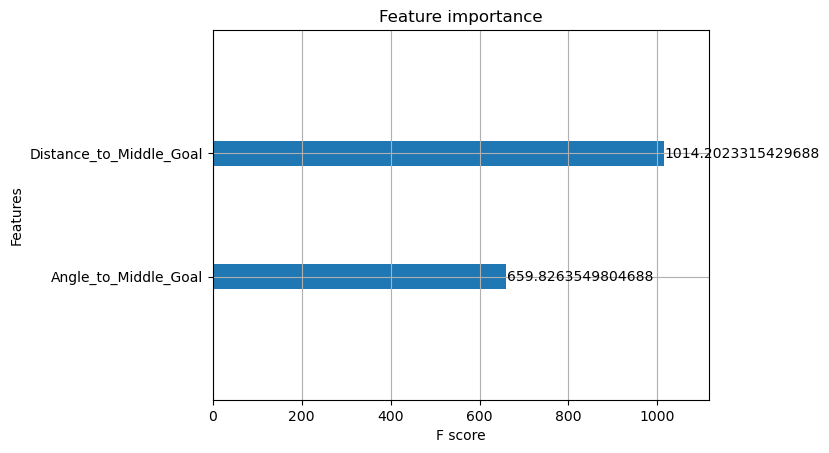

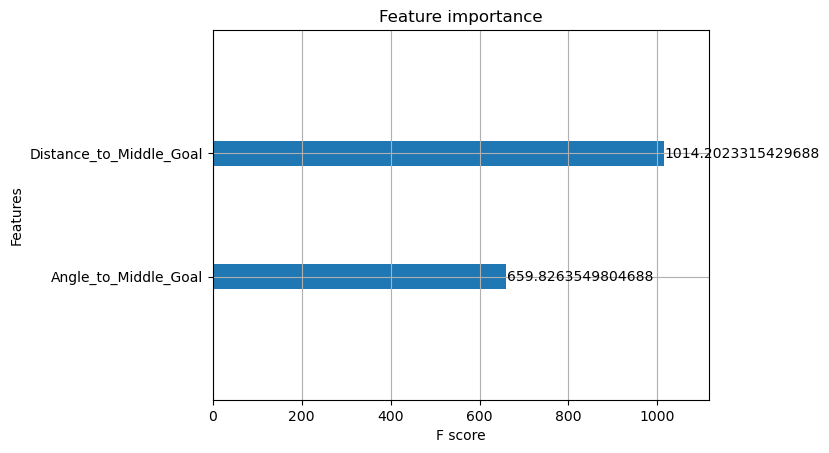

In [28]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

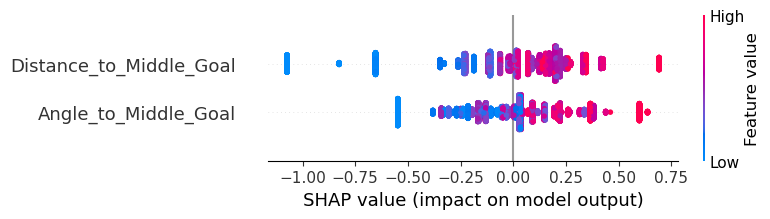

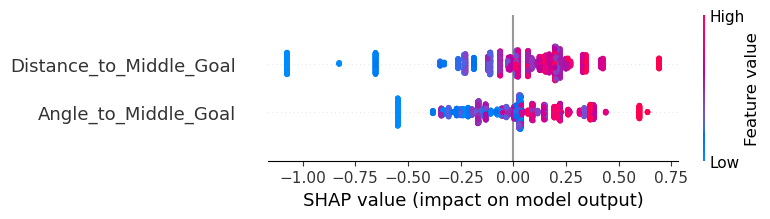

In [29]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [30]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_Goal', 'Angle_to_Middle_Goal']

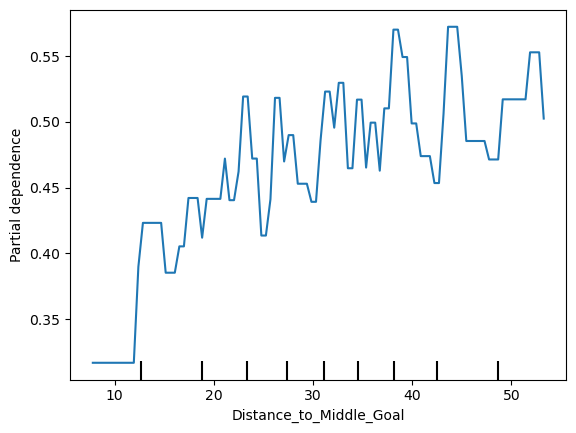

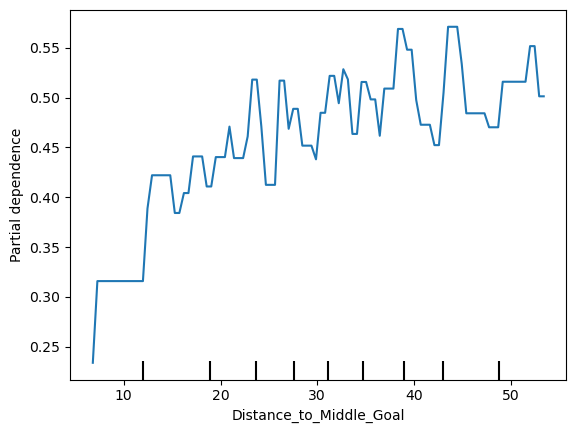

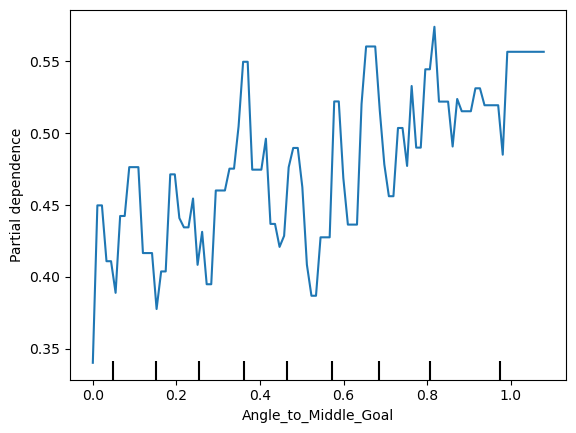

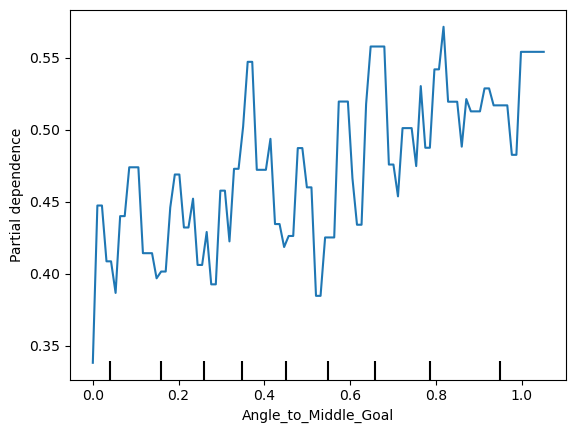

In [31]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

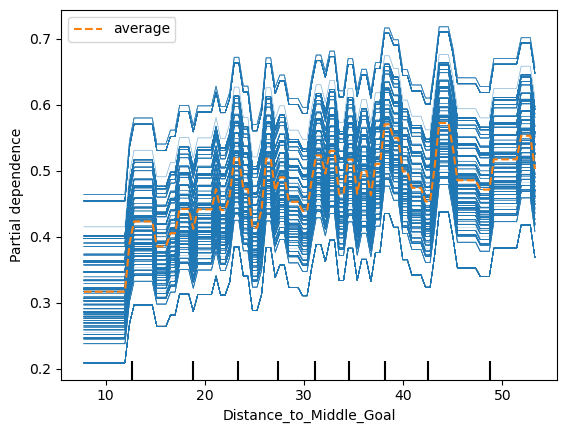

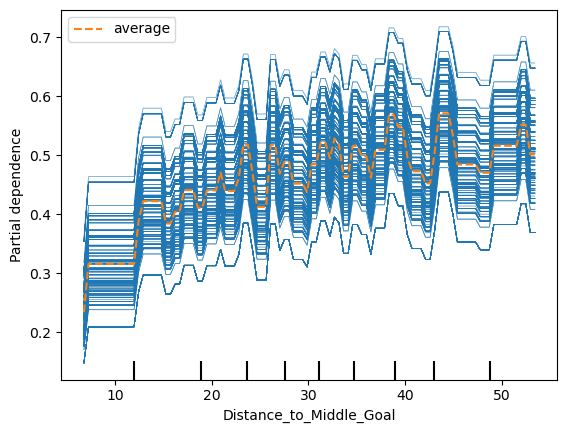

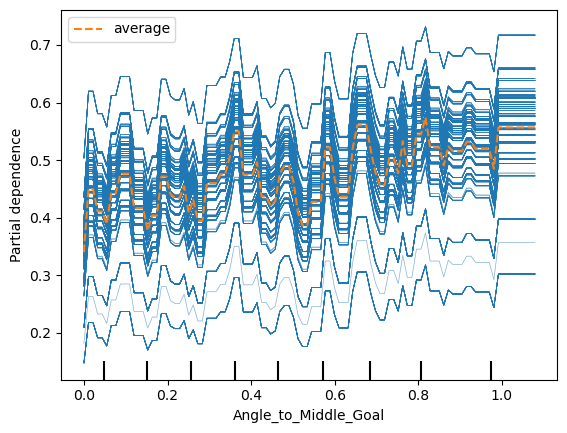

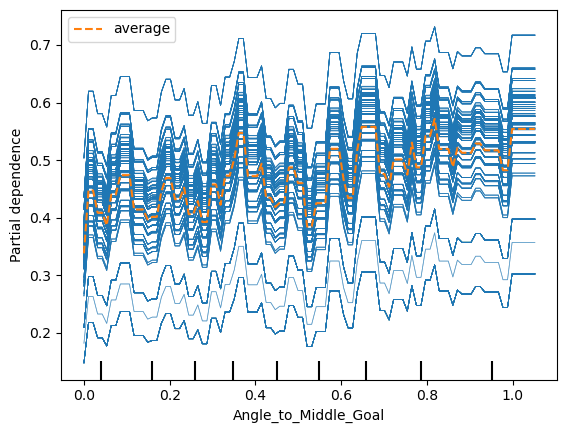

In [32]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

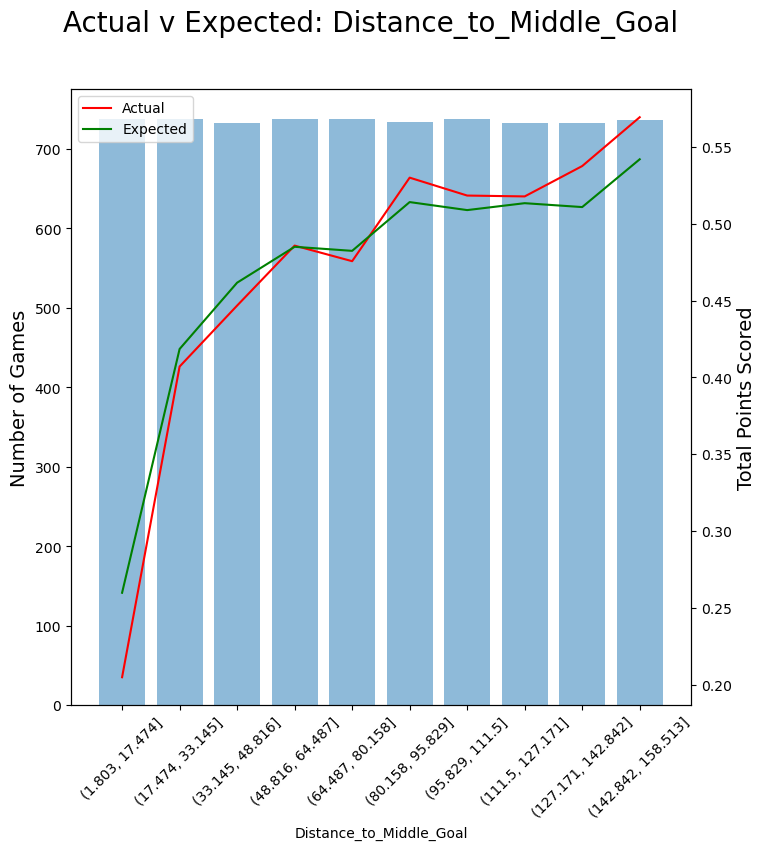

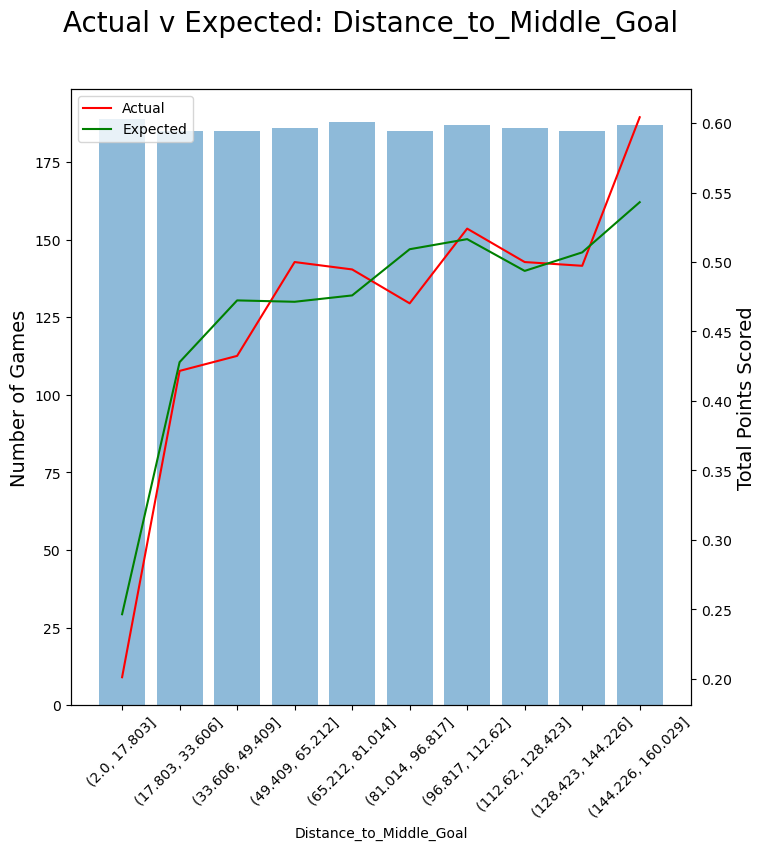

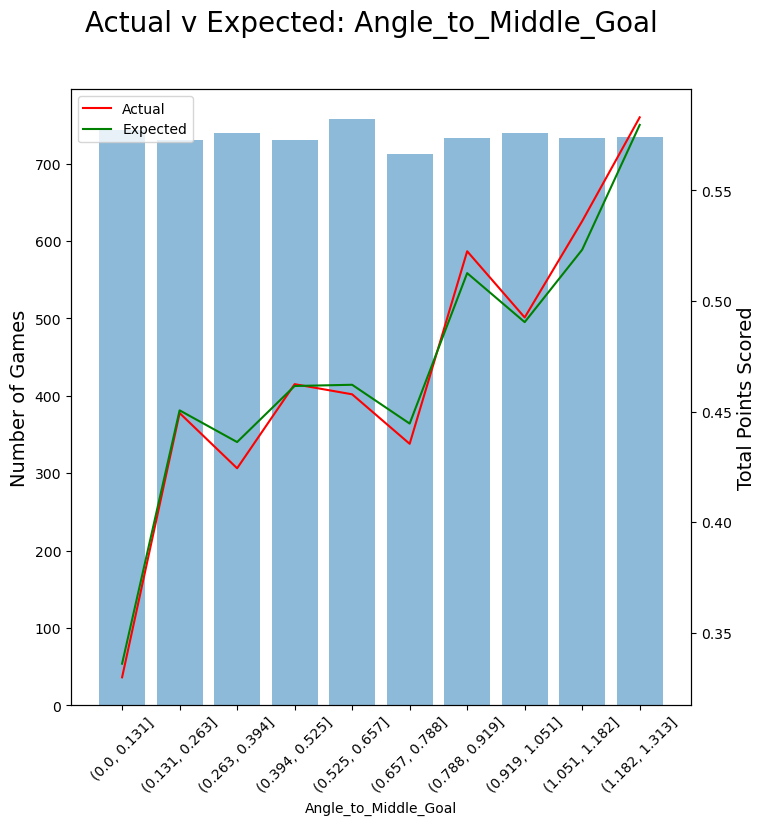

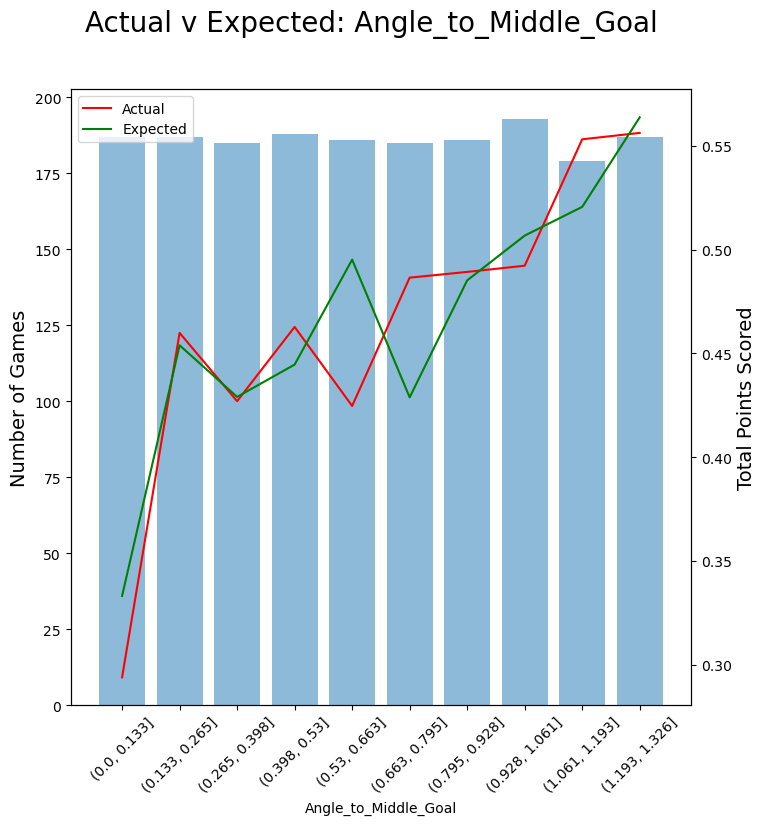

In [33]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [34]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

(0.6535706788849597, 0.6659647847531928)

In [35]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

(0.23130367772564447, 0.23745285204591698)

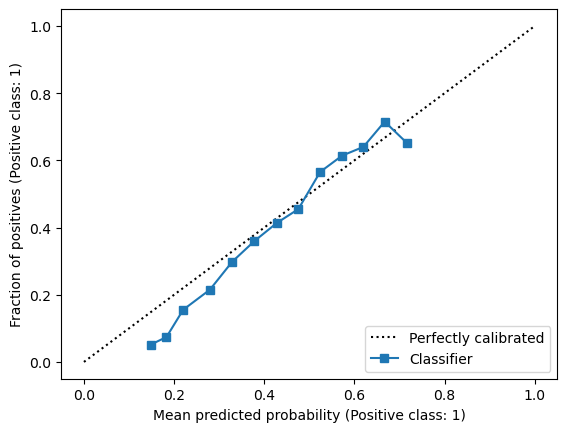

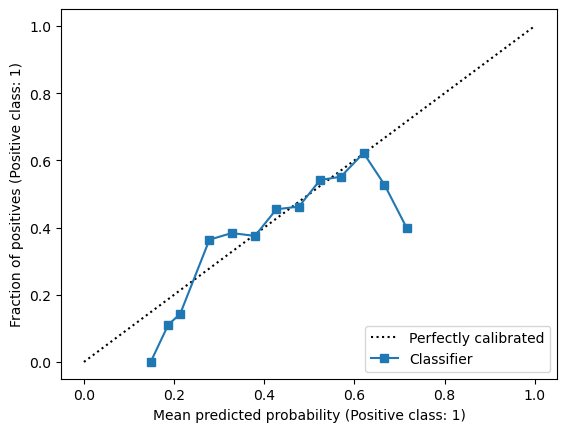

In [36]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [37]:
train_xgb_evals.get_auc_score(), test_xgb_evals.get_auc_score()

(0.6091137252280855, 0.5742838277711492)

In [38]:
train_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[2715, 1188],
        [1647, 1803]]),
 array([[664, 334],
        [447, 418]]))

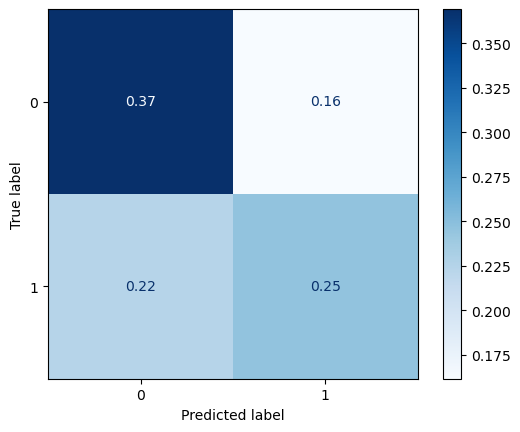

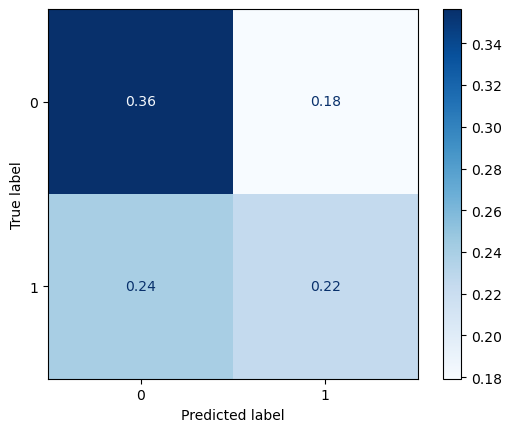

In [39]:
train_xgb_evals.display_confusion_matrix()
test_xgb_evals.display_confusion_matrix()

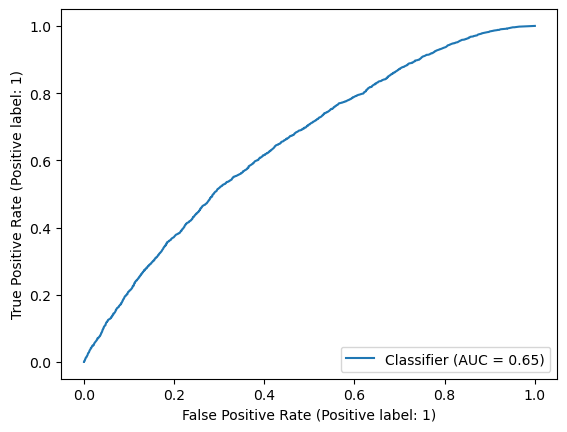

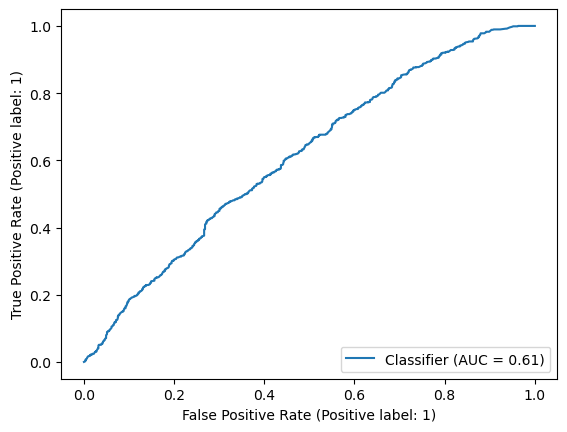

In [40]:
train_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

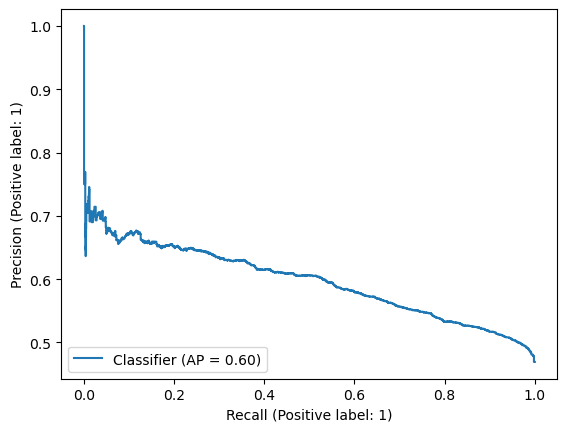

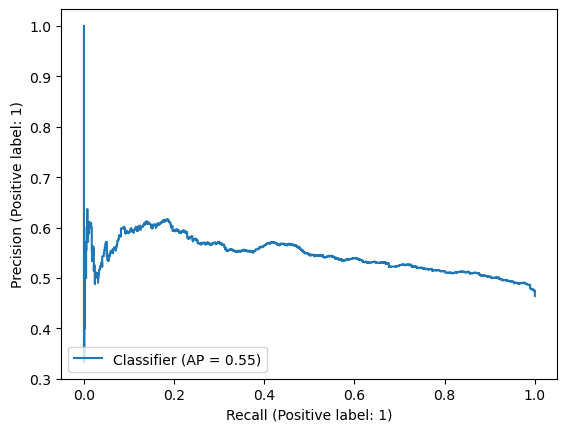

In [41]:
train_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

In [42]:
train_xgb_evals.get_accuracy(), test_xgb_evals.get_accuracy()

(0.6144430844553244, 0.5807836822329576)

In [43]:
train_xgb_evals.get_recall(), test_xgb_evals.get_recall()

(0.5226086956521739, 0.48323699421965316)

In [44]:
train_xgb_evals.get_precision(), test_xgb_evals.get_precision()

(0.6028084252758275, 0.5558510638297872)

In [45]:
train_xgb_evals.get_f1_score(), test_xgb_evals.get_f1_score()

(0.55985095482068, 0.5170068027210885)